In [1]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

Tight electron $p_{T}$ [GeV]

In [21]:
class testprocessor(processor.ProcessorABC):
    def __init__(self):
        


        self._accumulator = processor.dict_accumulator({ 

            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT','$m_{T}$ [GeV]',20,0,600)),
            'eT_miss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eT','$E^T_{miss}$[GeV]',20,0,600)),
            
            
            'ele_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight electron $p_{T}$ [GeV]', 10,0,200)),
            
            'mu_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Tight Muon $p_{T}$ [GeV]', 10,0,200)),
            
            'jet_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $AK4 Jet p_{T}$ [GeV]',
                        [30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 250.0, 280.0, 310.0, 340.0, 370.0, 400.0, 430.0, 470.0, 510.0, 550.0, 590.0, 640.0, 690.0, 740.0, 790.0, 840.0, 900.0, 960.0, 1020.0, 1090.0, 1160.0, 1250.0])),
            
            'dphi_e_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (e, E^T_{miss} )$', 30,0,3.5)),
            'dphi_mu_etmiss': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('dphi', '$\Delta\phi (\mu, E^T_{miss} )$', 30,0,3.5)),
        }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
 

        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        dataset = events.metadata['dataset'].split('_')[0]

#                 print("a JetHT dataset was found and the processor has excluded events with W_pT <100 GeV because we are trying to inspect the W+Jets Low pT sample")
        Electron = events.Electron
        Muon = events.Muon
        Met = events.MET
        Jet = events.Jet
#         else: pass
        #**********step 1 Object Selection*************** 
        '''
        1. Electrons: 
            a. Tight Electron
            b. Loose Electron
            c. Ele['T'] = ( pt*cos(phi), pt*sin(phi))
            d. Ele['p4']
        '''
        Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi)
        Electron['p4'] = TLorentzVectorArray.from_ptetaphim(Electron.pt, Electron.eta, Electron.phi, Electron.mass)
        
        TightEleSel = ~(Electron.pt==np.nan)
        TightEleSel = (((Electron.pt>40) &
                        (abs(Electron.eta)<1.4442) &
                        (abs(Electron.dxy)<0.05) &
                        (abs(Electron.dz)<0.1) &
                        (Electron.cutBased==4)) | 
                        ((Electron.pt>40) &
                         (abs(Electron.eta)>1.5660) &
                         (abs(Electron.eta)<2.5) &
                         (abs(Electron.dxy)<0.1) &
                         (abs(Electron.dz)<0.2) &
                         (Electron.cutBased==4)
                        )) # Trigger: HLT_Ele32_WPTight_Gsf_v
        
        LooseEleSel = ~(Electron.pt==np.nan)
        LooseEleSel = (((Electron.pt>10) &
                       (abs(Electron.eta)<1.4442) &
                       (abs(Electron.dxy)<0.05) &
                       (abs(Electron.dz)<0.1) &
                       (Electron.cutBased>=1)) |
                    ((Electron.pt>10) &
                     (abs(Electron.eta)>1.5660) &
                     (abs(Electron.eta)<2.5) &
                     (abs(Electron.dxy)<0.1) &
                     (abs(Electron.dz)<0.2) &
                     (Electron.cutBased>=1)))
        
        TightElectron = Electron[TightEleSel]
        LooseElectron  = Electron[LooseEleSel]
        LeadingEle = TightElectron[TightElectron.pt.argmax()]
#         output['ele_pt'].fill(dataset=dataset,
#                      region='everthing',
#                      pT = Electron.pt[LooseEleSel].flatten())

        '''
        2. Muons:
            a. Tight Muon
            b. Loose Muon
            c. Mu['T'] = ( pt*cos(phi), pt*sin(phi))
            d. Mu['p4']
        '''
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(Muon.pt, Muon.eta, Muon.phi, Muon.mass)
        
        TightMuSel = ~(Muon.pt==np.nan)
        TightMuSel = (
                    (Muon.pt>30) &
                    (abs(Muon.eta)<2.4) &
                    (Muon.tightId) &
                    (Muon.pfRelIso04_all<0.15)
                    )
        
        LooseMuonSel = ~(Muon.pt==np.nan)
        LooseMuonSel = (Muon.pt>15)&(abs(Muon.eta)<2.4)&(Muon.looseId>0)&(Muon.pfRelIso04_all<0.25)
        
        LooseMuon = Muon[LooseMuonSel]
        TightMuon = Muon[TightMuSel]
        LeadingMu = TightMuon[TightMuon.pt.argmax()]
        '''
        3. Photons:
            a. Loose photon
            b. Tight Photon
            
        '''
        Photon = events.Photon
        LoosePhoSel = ~(Photon.pt==np.nan)#just a complicated way to initialize a jagged array with the needed shape to True
        LoosePhoSel = (
                    (Photon.pt>15) &
                    ~((abs(Photon.eta) > 1.4442) &(abs(Photon.eta) < 1.566)) &
                    (abs(Photon.eta) < 2.5) &
                    (abs(Photon.cutBasedBitmap &1) == 1)
                    )

        TightPhoSel = ~(Photon.pt==np.nan)  
        TightPhoSel = ((Photon.pt>230)&((Photon.cutBasedBitmap&2)==2))

        LoosePhoton = Photon[LoosePhoSel] 
        TightPhoton = Photon[TightPhoSel]
        
#         output['ele_pt'].fill(dataset=dataset,
#              region='everthing',
#              pT = TightPhoton.pt.flatten())

        '''
        4. MET:
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        '''

        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        
        '''
        5. Jets:
        '''

        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]
        
        
        #******** step 2: triggers*******
        
        # single e triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf','Ele115_CaloIdVT_GsfTrkIdT','Photon200'] 
                                 
        
        # single mu triggers for µ events
        MuTrigger = ['IsoMu24',
                    'Mu50',
                    'OldMu100',
                    'TkMu100']   
        # Photon trigger
        PhoTrigger = ['Photon200'] 
                           
        
        # met trigger
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60','PFMETNoMu120_PFMHTNoMu120_IDTight'] 
        
        #************ calculate delta phi( leading ak4jet, met) > 1.5***********
        
        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]
        
        Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)
        
        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele        = LeadingJet['p4'].cross(TightElectron['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele<3.4).any()
        
        LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu<3.4).any()
        
        
        #*****btag 
        #https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X#Supported_Algorithms_and_Operati
        #medium     0.4184
        btagWP_medium = 0.4184
        Jet_btag_medium = Jet[Jet['btagDeepB'] > btagWP_medium]
        
        # ****** to add event selection in coffea ********
        
        selection = processor.PackedSelection()
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
        selection.add('TightMet', (Met.pt >= 100))
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)
        selection.add('one_electron', (TightElectron.counts == 1))
        selection.add('zero_loose_muon', (LooseMuon.counts == 0))
        selection.add('zero_loose_photon', (LoosePhoton.counts == 0))
        selection.add('zero_medium_btags', (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 0))
        selection.add('Delta_Phi_Met_LJ', (Delta_Phi_Met_LJ))
        selection.add('DeltaR_LJ_Ele', (DeltaR_LJ_Ele_mask))
        
        selection.add('one_muon', (TightMuon.counts == 1))
        selection.add('zero_loose_electron', (LooseElectron.counts == 0))
        selection.add('DeltaR_LJ_Mu', (DeltaR_LJ_Mu_mask))
        
        selection.add('atleast_2_medium_btag', (Jet[Jet['btagDeepB'] > btagWP_medium].counts >= 2))
        
        selection.add('exactly_1_medium_btag', (Jet[Jet['btagDeepB'] > btagWP_medium].counts == 1))
        
        '''
        what the next 6 lines of code do:
        
        main object is to exclude events from JetHt sample with W_pT b/w 70-100 GeV
        
        events.metadata['dataset'] = 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____27_'
        dataset = 'WJetsToLNu'
        
        see if the 'HT' is in the name of the sample
        so, it first goes to genpart,
        figures out if the genlevel process is hardprocess and firstcopy and there are genlevel particle with 
        abs(pdgID)= 24
        
        ad selects only those events for the pT of W was > 100 GeV
            
        '''
        
        selection.add("exclude_low_WpT_JetHT", np.full(len(events), True)) # predclration just in cas I don't want the filter
        if dataset == 'WJetsToLNu':
            if events.metadata['dataset'].split('-')[0].split('_')[1] == 'HT':
                GenPart = events.GenPart
                remove_overlap = (GenPart[GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) &
                                    ((abs(GenPart.pdgId) == 24))].pt > 100).all()
                selection.add("exclude_low_WpT_JetHT", remove_overlap)
                
        else:
            selection.add("exclude_low_WpT_JetHT", np.full(len(events), True))
# i dont think I need a photon trigger
#         triggers = np.zeros(events.size, dtype=np.bool)
#         for path in PhoTrigger:
#             if path not in events.HLT.columns: continue
#             triggers = triggers | events.HLT[path]
#         selection.add('pho_triggers', triggers)
        
        
        selection.add('DeltaR_LJ_mask', (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))
        
#  
        region = {
            'wecr' : (selection.all(*('met_triggers', 
                                     'ele_triggers', 
                                     'TightMet', 
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'zero_medium_btags',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                    )), 
                     np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                     ),
            'wmucr' : (selection.all(*('met_triggers', 
                                     'mu_triggers', 
                                     'TightMet', 
                                     'one_muon',
                                     'zero_loose_electron',
                                     'zero_loose_photon',
                                     'zero_medium_btags',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                    'exclude_low_WpT_JetHT'
                                    )),
                      np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                      ),
            'tecr': (selection.all(*('met_triggers', 
                                     'ele_triggers', 
                                     'TightMet', 
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'atleast_2_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                    )),
                    np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                    ),
            'tmucr': (selection.all(*('met_triggers', 
                                     'ele_triggers', 
                                     'TightMet', 
                                     'one_muon',
                                     'zero_loose_electron',
                                     'zero_loose_photon',
                                     'atleast_2_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                      'exclude_low_WpT_JetHT'
                                    )),
                     np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                     ),
            'secr': (selection.all(*('met_triggers', 
                                     'ele_triggers', 
                                     'TightMet', 
                                     'one_electron',
                                     'zero_loose_muon',
                                     'zero_loose_photon',
                                     'exactly_1_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                     'exclude_low_WpT_JetHT'
                                    )),
                    np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum()))))
                    ),
            'smucr': (selection.all(*('met_triggers', 
                                     'ele_triggers', 
                                     'TightMet', 
                                     'one_muon',
                                     'zero_loose_electron',
                                     'zero_loose_photon',
                                     'exactly_1_medium_btag',
                                     'Delta_Phi_Met_LJ',
                                     'DeltaR_LJ_Ele',
                                      'exclude_low_WpT_JetHT'
                                    )),
                     np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum()))))
                     )
            
        
        }
        
        
        
#         region={
#             'secr': "exactly one b-tagged jet and one e",
#             'smucr': "exactly one medium b-tagged jet and one mu selection"
#             'tecr': "atleast 2 medium b-tagged jets and one e",
#             'tmucr':"atleast 2 medium b-tagged jets and one mu",
#             'wecr': "no medium b-tagged jets and has one e",
#             'wmucr': "no medium b-tagged jets and has one mu"
#         }

        mT = {
            'wecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'tecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'wmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))),
            'tmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))) 
        } 
   
        for reg, sel_mt in region.items():
            output['mT'].fill(dataset=dataset,
                             region=reg,
                             mT = sel_mt[1][sel_mt[0]].flatten())
            output['eT_miss'].fill(dataset=dataset,
                             region=reg,
                             eT= Met[sel_mt[0]].pt.flatten())
            output['ele_pT'].fill(dataset=dataset,
                             region=reg,
                             pT= TightElectron[sel_mt[0]].pt.flatten())
            output['mu_pT'].fill(dataset=dataset,
                 region=reg,
                 pT= TightMuon[sel_mt[0]].pt.flatten()),
            
        
        return output   
    def postprocess(self, accumulator):
        return accumulator

In [17]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_13.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_130.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_131.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_132.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_133.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_134.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_135.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_136.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_137.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_138.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_139.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_14.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_140.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_141.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_142.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_143.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_144.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_145.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_146.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_147.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_148.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_149.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_15.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_150.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_151.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_152.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_153.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_154.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_155.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ],
          'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_':
          [
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_1.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_10.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_108.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_109.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_11.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_110.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_111.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_112.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_113.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_114.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_115.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_116.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_117.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_118.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_119.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_12.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_120.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_121.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_122.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_123.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_124.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_125.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_126.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_127.root"
        ]}
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=testprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

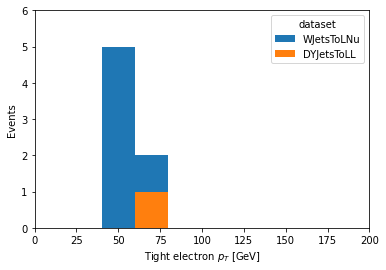

In [28]:
hist.plot1d(output['ele_pT'].integrate('region'), overlay='dataset', stack=True)